# Bear Classification (Final Report)

[LINK TO PROJECT REPO](https://github.com/rpforrest1/Bear_Classification_CNN_Project)

## Introduction

The main purpose of this project is to create a CNN model that will classify 3 different types of bears, black bears, grizzly bears and teddy bears. The data was sourced from kaggle at this location: [Bears FastAI 2021](https://www.kaggle.com/datasets/anirudhg15/bears-fastai-2021). Another purpose of this project is to experiment with setting up multi-class classification CNN models.

The data consists of 3 folders of bear images. The 'black' folder contains 96 images of black bears. The 'grizzly' folder contains 98 images of grizzly bears and the 'teddy' folder contains 94 images of teddy bears. The images were sourced from DuckDuckGo by the dataset creator, so all images are of varying formats and sizes (which will be discussed in more detail later).

In [1]:
# Remove TF logging warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import json
from model_building.model_helper_functions import (CLASS_NAMES, plot_metric, plot_learning_rate, bold, load_results,
                                                map_to_metrics, calculate_performance)
from model_building.data_pipeline import prep_data, get_train_val_test_data, create_tensorflow_datasets
import tensorflow as tf
import os
import re

In [3]:
print('Tensorflow version', tf.__version__)

Tensorflow version 2.13.0


In [4]:
# Remove TF logging warnings
tf.get_logger().setLevel('ERROR')

In [5]:
raw_data_dir = './bears_raw'
data_dir = 'bears'

---

## Exploratory Data Analysis

In [6]:
def load_images(data_dir):
    """
    Loads the dataset of images into a dataframe.

    Args:
        data_dir: The directory where the images are placed.
    
    Returns:
        A dataframe of the images
    """
    
    bear_images = []
    for folder in os.listdir(data_dir):
        if folder not in CLASS_NAMES:
            continue
    
        for filename in os.listdir(f'{data_dir}/{folder}'):
            if 'g' in filename.lower(): #Make sure to only get images
                im = Image.open(f'{data_dir}/{folder}/{filename}')
                bear_images.append((folder, filename, im))
                
    bear_images = pd.DataFrame.from_records(bear_images, columns=['label', 'filename', 'img'])
    bear_images['image_width'] = bear_images['img'].apply(lambda x: x.size[0])
    bear_images['image_height'] = bear_images['img'].apply(lambda x: x.size[1])
    bear_images['image_format'] = bear_images['img'].apply(lambda x: x.format)

    return bear_images

In [7]:
def plot_examples(label:str, num_examples=8):
    """
    Plots example images.

    Args:
        label: Will be either 'black', 'grizzly', or 'teddy'.
        num_examples: The number of examples to plot

    Returns:
        None. Plots the images.
    """
    
    example_set = og_bear_images[og_bear_images['label'] == label]
    
    if num_examples == 4:
        plt.figure(figsize=(num_examples*2, num_examples*2))
    else:
        plt.figure(figsize=(num_examples+1, num_examples+1))
    
    for i in range(num_examples):
        if num_examples == 4:
            ax = plt.subplot(num_examples, num_examples, i + 1)
        else:
            ax = plt.subplot(int(num_examples/2), int(num_examples/2), i + 1)
        plt.imshow(example_set.iloc[i]['img'])
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.axis("off")

In [8]:
og_bear_images = load_images(raw_data_dir)

Example of black bear images.


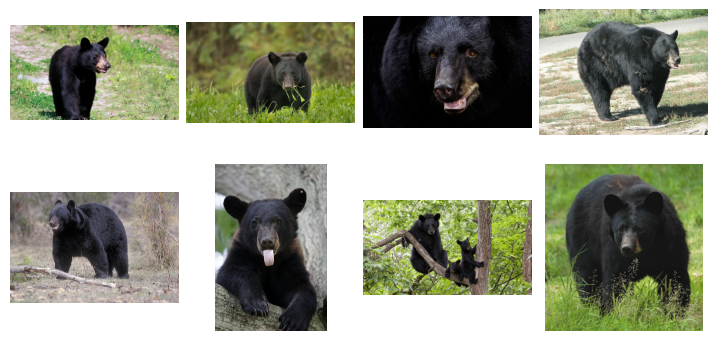

In [9]:
print(bold('Example of black bear images.'))
plot_examples('black', num_examples=8)

Example of grizzly bear images.


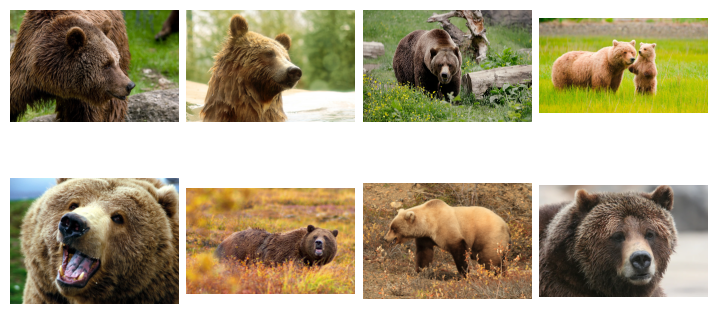

In [10]:
print(bold('Example of grizzly bear images.'))
plot_examples('grizzly', num_examples=8)

Example of teddy bear images.


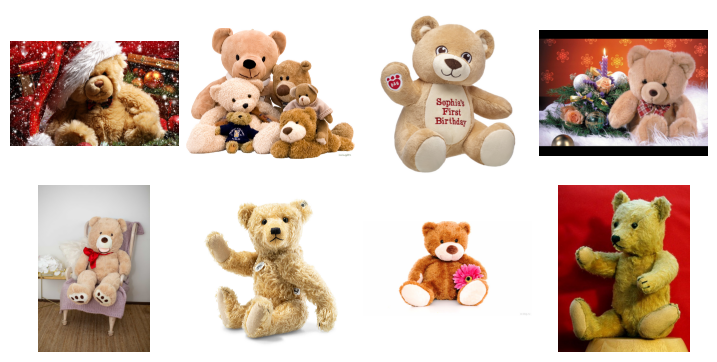

In [11]:
print(bold('Example of teddy bear images.'))
plot_examples('teddy', num_examples=8)

So far, it looks like black bears are darker that grizzly bears, and the teddy bear images vary wildly. Due to how distinct the 3 classes appear to be, I believe it will be possible to use CNNs to create an effective classification model.

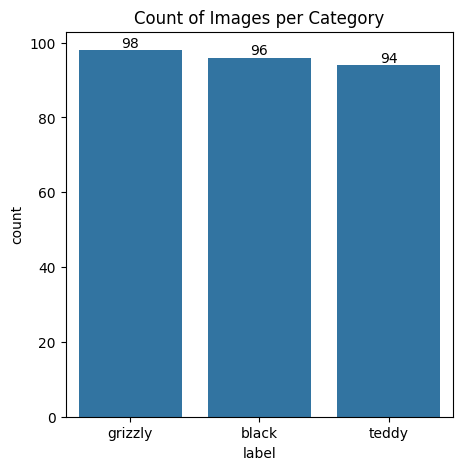

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
_ = sns.countplot(og_bear_images, x='label', ax=ax, stat='count')
plt.title('Count of Images per Category')
plt.bar_label(ax.containers[0])
plt.show()

The images per class are all very close. One drawback is that I'm not sure is almost 100 images per category will be enough to make an effective model. I will consider adding data augmentation to the model pipeline in order to have more data data to train with.

Lets take a look at the distribution of images sizes per bear class.

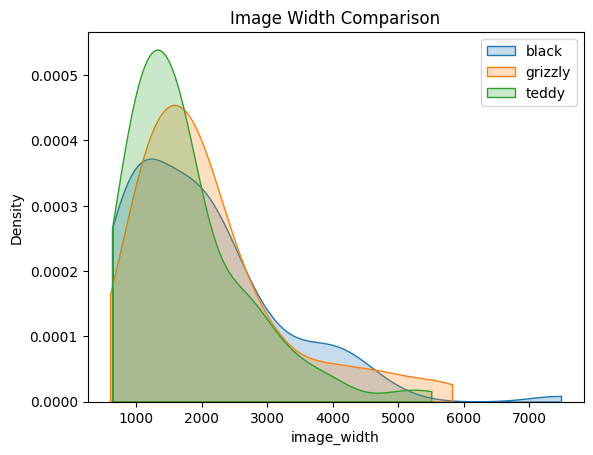

In [13]:
plt.title(f'Image Width Comparison')
for group, group_df in og_bear_images.groupby('label'):
    ax = sns.kdeplot(group_df['image_width'], label=group, cut=0, fill=True)
_ = plt.legend()

In [14]:
print(bold('Average image width per class'))
display(og_bear_images[['label', 'image_width']].groupby(['label']).mean().round(1))

Average image width per class


,image_width
label,
black,1973.9
grizzly,2084.7
teddy,1752.8


As we can see in the chart above, there is a lot of variation in the image widths between the 3 classes. The black bear images have widths that can be quite long when compared to the other 2 classes. From the table, we can see that the average image width is around 2000 pixels for black and grizzly bears but is noticably smaller for teddy bears. I believe this will be due to the teddy bear images having more variety in their background.

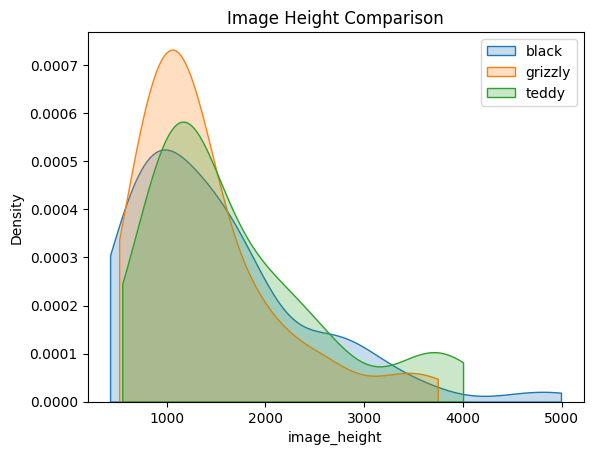

In [15]:
plt.title(f'Image Height Comparison')
for group, group_df in og_bear_images.groupby('label'):
    sns.kdeplot(group_df['image_height'], label=group, cut=0, fill=True)
_ = plt.legend()

In [16]:
print(bold('Average image height per class'))
display(og_bear_images[['label', 'image_height']].groupby(['label']).mean().round(1))

Average image height per class


,image_height
label,
black,1497.8
grizzly,1382.7
teddy,1681.1


For the image heights, the results look similar to what the width results were. Black bears again have the largest images. The average height appears to have more variation between the classes and surprisingly the teddy bear class has the largest average height.

Due to the variation in images sizes, there will be a data cleaning step where all the images are standardized to a common size (which will be discussed later).

Now lets look at the image formats. This will be important to understand so that the model reads in a consistant format.

In [17]:
display(og_bear_images[['label', 'image_format', 'img']].groupby(['label', 'image_format']).count())

img
label   image_format     
black   JPEG           87
        PNG             1
        WEBP            8
grizzly JPEG           85
        WEBP           13
teddy   JPEG           77
        PNG            10
        WEBP            7

Based on these results, there is unfortunately a lot of variation with the image formats as well. I did some testing on the side and the WEBP format caused a lot of issues when reading into tensorflow. To make the modeling process smoother, I will also standardize the image formats to JPEG.

When looking for outliers, to the best of my abilities I verified that all images belonged to the class that they were originally given by the dataset curator.

---

## Data Preprocessing

From the EDA results, we saw that there is a lot of variation between the image files. This would add unnecessary complexity to the model that can otherwise be mitigated by preprocessing the data.

A python file called 'data_setup.py' [linked here](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/data_setup.py) was created that takes in the raw image data and standardizes the image into a common structure. The new images will have a size of 400 x 400 (while keeping aspect ratio). When doing some experimentation, 400 x 400 appeared to be a good size that maintains as much of the original context as possible. The aspect ratio is kept by applying white padding to the images. White was used since it should have a lower impact on the model compared to black, since the model will ultimately be classifing black bears. The images will also be converted to JPEG with RGB coloring.

During model creation, the pixel values will be transformed to be between 0 and 1 since values of 255 are not ideal for the model. Data augmentation techniques such as random flipping, rotating, and zooming will also be applied since the dataset count is rather low. This will be discussed in detail later on.

In [18]:
new_bear_images = load_images(data_dir)

In [19]:
display(pd.pivot_table(new_bear_images, index='label',
                       values=['image_width', 'image_height', 'image_format'], aggfunc=['max', 'min', 'count']))

max                                   min               \
        image_format image_height image_width image_format image_height   
label                                                                     
black           JPEG          400         400         JPEG          400   
grizzly         JPEG          400         400         JPEG          400   
teddy           JPEG          400         400         JPEG          400   

                           count                           
        image_width image_format image_height image_width  
label                                                      
black           400           96           96          96  
grizzly         400           98           98          98  
teddy           400           94           94          94

From the table above, the data preprocess was a success since now all 288 images are 400 x 400 with the JPEG format. Now we can verify the white padding was applied correctly (which will appear seemless, so its mostly to confirm no abnormal stretching was applied).

Example of converted black bear images.


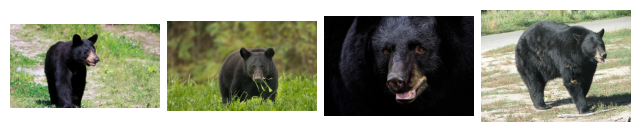

In [20]:
print(bold('Example of converted black bear images.'))
plot_examples('black', num_examples=4)

Example of converted grizzly bear images.


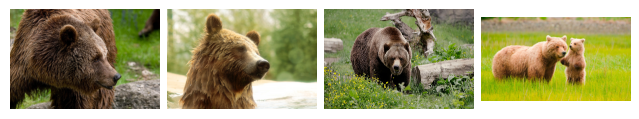

In [21]:
print(bold('Example of converted grizzly bear images.'))
plot_examples('grizzly', num_examples=4)

Example of converted teddy bear images.


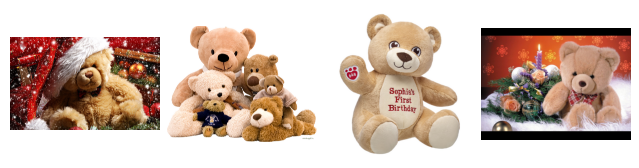

In [22]:
print(bold('Example of converted teddy bear images.'))
plot_examples('teddy', num_examples=4)

None of the images look stretched or warped in any way, so preprocessing turned out successful. The final image in the teddy bear class above, has black padding from the original image. The preprocessing done here will not alter images where this appeared in the original image. This should not pose an issue to the model.

---

## Model Architecture and Tuning

For the model architecture, I will take most of my inspiration from VGGNet due to its simplicity and past familiarity with the architecture. I will use a \[Convolution -> Convolution -> Max Pool] x Depth approach since its a good architecture for image classiication and can be easily expanded. I am interested in learning how many of these convolution segments are needed to get good results. I will do hyperparameter tuning in order to find the best parameters. I will create a new batch of models for each new set of parameters that I intend to modify.

The modeling pipeline will start out by taking a stratified random sample of images from the processed dataset of 400 x 400 JPEG images. The 'data_pipeline.py' file [linked here](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/data_pipeline.py) is used to handle the modeling pipeline in general. Training set will be 70%, validation set 22.5% and the test set is 7.5% of the data. The pixel values are all normalized to be between 0 and 1 by dividing the values by 255.

The major backbone to all model fitting will be the 'model_helper_functions.py' file [linked here](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/model_helper_functions.py) and the notebook files (numbered by batches) [LINKED HERE](https://github.com/rpforrest1/Bear_Classification_CNN_Project/tree/main/model_building/trained_notebooks). Within the notebook files, will be the a hyperparameter grid for all model combinations to fit. The results are exported during training and will be read into this report notebook.

I'll start off by going the first batch of models from this notebook here [Multi_Model_Building_(Batch_1)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_1)_trained.ipynb). I'll explain all of the hyperparameters that will be tested below. In general, each value in the list will correspond to a different value to use as a parameter.
- `g_batch_size = [4, 8]`: This is the batch size to use.
- `g_epochs = [20]`: The max number of epochs to run.
- `g_augmentation_params = [None, (True, 0.25, 0.25, 'horizontal')]`: If None, no data augmentation layer is used. Otherwise, the tuple is structured like so: (flip, rotate_factor, zoom_factor, random_flip_str). The random_flip_str will be something like 'horizonal' or 'horizontal_and_vertical'.
- `g_cnn_params = [[(32,), [(3,3)], [(1,1)]], [(32, 64), [(5,5), (3,3)], [(2,2), (1,1)]]]`: There will be 1 list provide for each configuration. The way the list is set up is as such \[(1st_convolution_kernal_size, 2nd_convolution_kernal_size), \[1st_filter_tuple, 2nd_filter_tuple\], \[1st_filter_stride, 2nd_filter_stride]]. Recall that a  \[Convolution -> Convolution -> Max Pool] architecture is being used.
- `g_dropout = [0, 0.5]`: The dropout percentage to apply right after a MaxPool layer.
- `g_dense_units = [(32, 3), (64, 3)]`: For the classifier portion of the CNN model, this provides the number of units in each layer. 3 units are required in the final layer since there are 3 classes. Each tuple is a different configuration to run.
- `g_activation = ['relu']`: The activation function to use for all layers.
- `g_optimizer = [Adam]`: The optimizer object to use.
- `g_earlystop_patience = [5, 10]`: Early stopping is applied to all models. The number provided will be the patience value. If the validation accuracy hasn't increased after that many epochs, the training will stop.
- `g_reducel_patience = [1]`: Reducing the learning rate is applied to all models. The number provided will be the patience value. If the validation accuracy hasn't increased after that many epochs, the learning rate is cut in half.

Some modeling parameters are not altered such as:
- When using random zoom or random rotate, the fill_mode is set to 'reflect'
- The accuracy metric uses keras.metrics.SparseCategoricalAccuracy
- BatchNormalization is applied right before each activation function in the convolutional layers
- MaxPooling2D with size (2, 2) is applied at the end of every convolutional segment
- The loss function is tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
- The starting learning rate for any optimizer is 0.00001
- The factor used for ReduceLROnPlateau is set to 0.5
- ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau are all monitoring for the max validation accuracy

There are a total of **64** models fitted in the 1st batch using this notebook [Multi_Model_Building_(Batch_1)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_1)_trained.ipynb). I will go through some results below.

In [23]:
df = prep_data(data_dir)
train_df, val_df, test_df = get_train_val_test_data(df)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


In [24]:
# Load result for modeling batch #1
progress_batch1, model_data_batch1, all_val_metrics_batch1, full_results_batch1 = load_results('./model_building/model_checkpoints_1')
print(bold(f'Top 10 accuracy values on validation dataset.'))
display(all_val_metrics_batch1.sort_values('accuracy', ascending=False).head(10))

Top 10 accuracy values on validation dataset.


,loss,accuracy,total_time,ran_epochs,best_epoch
model3,1.225902,0.800000,101.599247,20,11
model2,1.225902,0.800000,82.801968,16,11
model35,1.735437,0.784615,74.293246,20,20
model19,1.239455,0.753846,122.478696,20,17
model18,1.239455,0.753846,122.333219,20,17
model17,1.136523,0.738462,106.136390,20,16
model1,1.021889,0.723077,87.313822,20,13
model0,1.021889,0.723077,80.213360,18,13
model16,0.622758,0.707692,85.791277,16,11
model9,0.701269,0.692308,22.978733,20,17


In [25]:
print(f'The highest best epoch for model batch #1 was {all_val_metrics_batch1.best_epoch.max()}.')

The highest best epoch for model batch #1 was 20.


In [26]:
print(bold('Model configuration for model-3'))
display(progress_batch1.loc['model3'])

Model configuration for model-3


batch_size                                       4
epochs                                          20
augmentation_params                           None
cnn_params             [(32,), [(3, 3)], [(1, 1)]]
dropout                                        0.0
dense_units                                (64, 3)
activation                                    relu
optimizer                                     Adam
earlystop_patience                              10
reducel_patience                                 1
finished                                      True
Name: model3, dtype: object

So far, there appears to be some good results from the hyperparameter searching. Lets take a look at the results in more detail in order to determine which parameters appear to be the most important.

In [27]:
hyperparams = ['batch_size', 'epochs', 'augmentation_params', 'cnn_params', 'dropout',
               'dense_units', 'activation', 'optimizer', 'earlystop_patience',
               'reducel_patience']

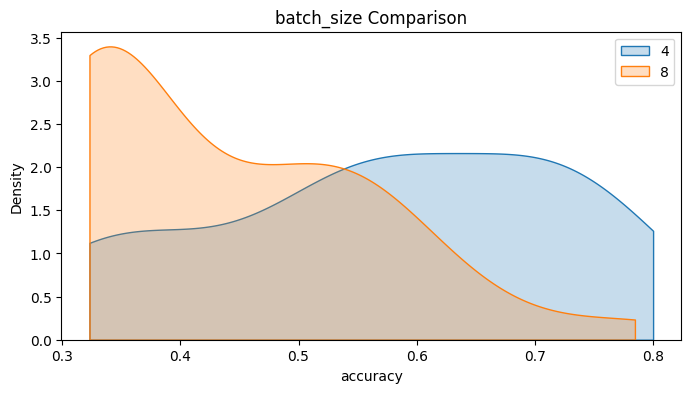

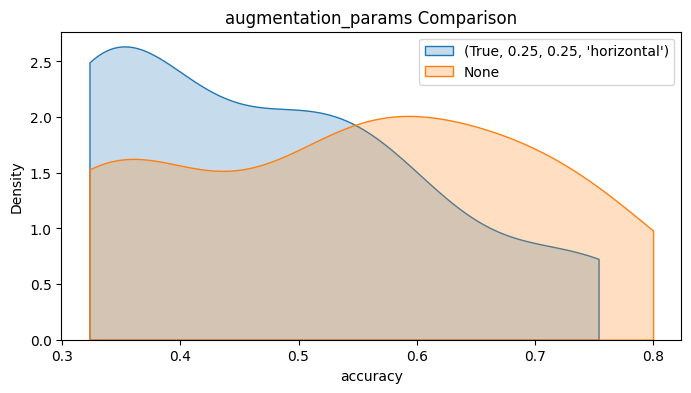

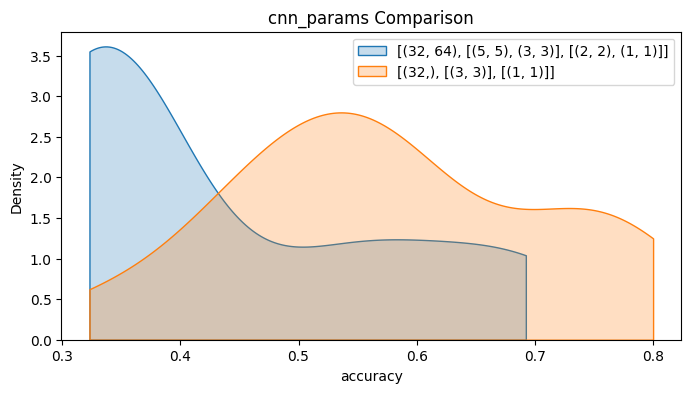

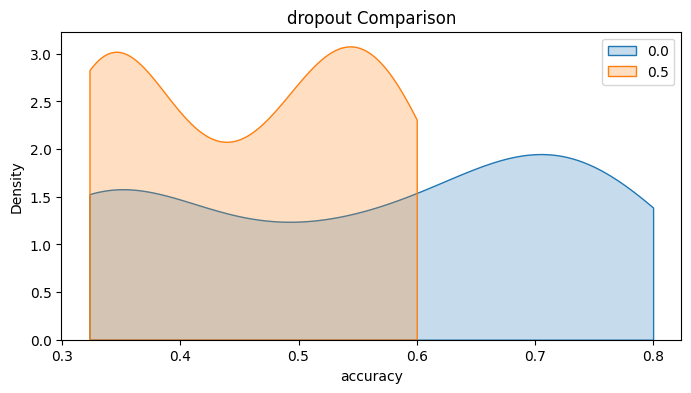

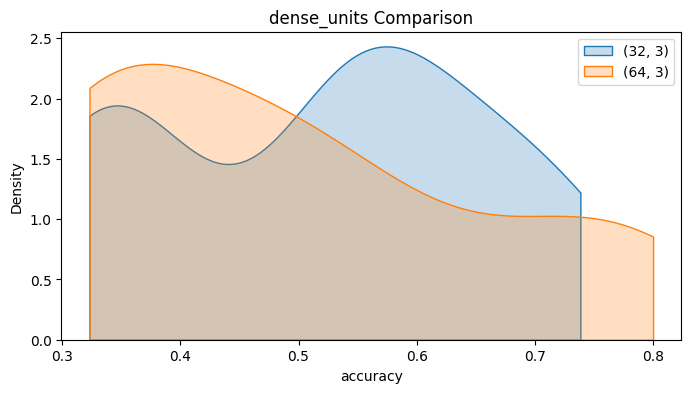

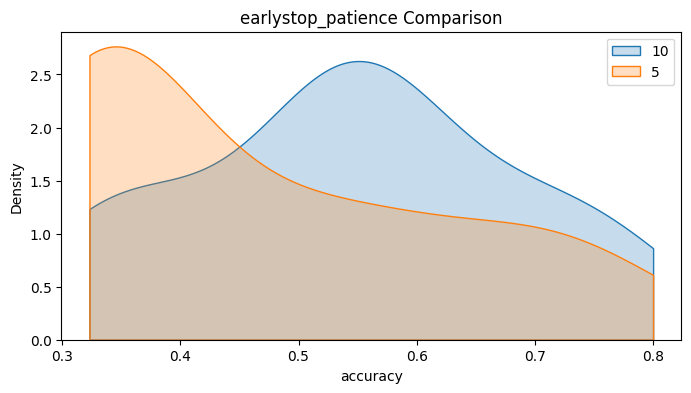

In [28]:
# Only want to plot the parameters that were tested.
for param in [c for c in hyperparams if c not in ['activation', 'optimizer', 'epochs', 'reducel_patience']]:
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f'{param} Comparison')
    for group, group_df in full_results_batch1.groupby(param):
        sns.kdeplot(group_df['accuracy'], label=group, cut=0, fill=True, ax=ax)
    _ = plt.legend()
    plt.show()

After looking through the results, here are some takeaways:
- batch_size: A batch size of 4 appears to be best. A batch size of 8 isn't bad, but the likelihood of getting good accuracy is lower.
- augmentation_params: Surprisingly, having no data augmentation layer leads to better accuracy. I believe the data augmentation isn't working as expected since the augmentation isn't providing new information. The augmentation is likely not strong enough to lead to data that appears new. I would like to test this a little more to make sure its not usefull.
- cnn_params: A single CNN segment of Convolution -> Convolution -> MaxPool leads to better results. The filter sizes were 3x3 and a stride of 1x1 was used. This simpler CNN model appears to be enough to do the necessary classification. I'd like to explore this some more to see if a deeper network would be better.
- dropout: Using no dropout turned out to be best. This is slightly surprising, but its still interesting to see that applying dropout and batch normalization at the same time, isn't ideal for this task.
- dense_units: For the classifier portion of the CNN model, using 64 units followed by 3 units is the best. Since using 64 units have a thinner tail in the distribution, I'd like to continue testing this parameter to see how many units would be best.
- earlystop_patience: Using a patience of 5 or 10 turns out to be ok. I believe a patience of 10 would lead to models with higher accuracy. A risk would be that overfitting would occur, even though there are already some overfitting mitigations put in place.

I'll take what I learned with the first batch of models, and create a new batch of models [Multi_Model_Building_(Batch_2)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_2)_trained.ipynb) with these parameters. (I'll list out the new parameters, but will skip the re-explanations.)

- `g_batch_size = [4]`
- `g_epochs = [35]`
- `g_augmentation_params = [None, (True, 0.5, 0.5, 'horizontal')]`
- `g_cnn_params = [[(32,), [(3,3)], [(1,1)]], [(32, 64), [(3,3), (3,3)], [(1,1), (1,1)]]]`
- `g_dropout = [0]`
- `g_dense_units = [(18, 3), (32, 3), (64, 3)]`
- `g_activation = ['relu', 'sigmoid']`
- `g_optimizer = [Adam, RMSprop]`
- `g_earlystop_patience = [15]`
- `g_reducel_patience = [2]`

There are a total of **48** models fitted in the 2nd batch using this notebook [Multi_Model_Building_(Batch_2)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_2)_trained.ipynb). I will go through some results below.

In [29]:
# Load result for modeling batch #2
progress_batch2, model_data_batch2, all_val_metrics_batch2, full_results_batch2 = load_results('./model_building/model_checkpoints_2')
print(bold(f'Top 10 accuracy values on validation dataset.'))
display(all_val_metrics_batch2.sort_values('accuracy', ascending=False).head(10))

Top 10 accuracy values on validation dataset.


,loss,accuracy,total_time,ran_epochs,best_epoch
model23,0.464846,0.907692,173.929025,35,23
model19,0.506365,0.876923,155.425694,35,21
model25,0.573150,0.861538,233.159757,35,20
model47,0.609000,0.861538,191.594647,32,17
model5,0.508481,0.861538,122.105866,26,11
model43,0.752518,0.846154,145.747546,27,12
model1,0.855951,0.830769,141.278592,25,10
model33,0.615058,0.830769,189.438877,28,13
model32,1.087291,0.815385,159.123984,27,12
model45,0.705747,0.800000,162.042060,27,12


In [30]:
print(bold('Model configuration for model-23'))
display(progress_batch2.loc['model23'])

Model configuration for model-23


batch_size                                                          4
epochs                                                             35
augmentation_params                                              None
cnn_params             [(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]
dropout                                                             0
dense_units                                                   (64, 3)
activation                                                    sigmoid
optimizer                                                     RMSprop
earlystop_patience                                                 15
reducel_patience                                                    2
finished                                                         True
Name: model23, dtype: object

In [31]:
print(f'The highest best epoch for model batch #2 was {all_val_metrics_batch2.best_epoch.max()}.')

The highest best epoch for model batch #2 was 32.


After running the 2nd batch of models, there were many models created that performed better than the 1st batch of models. Lets take a more detailed look on how the models did.

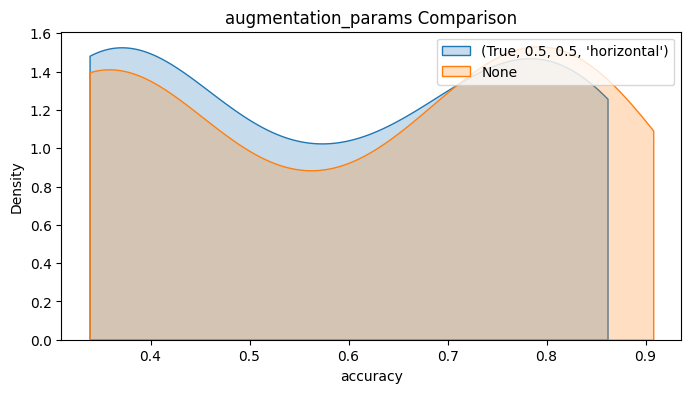

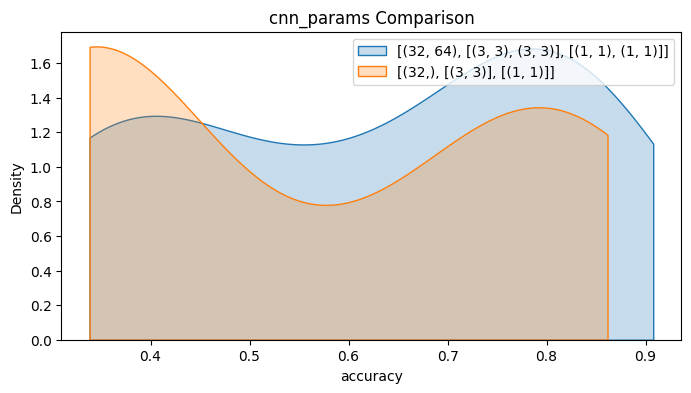

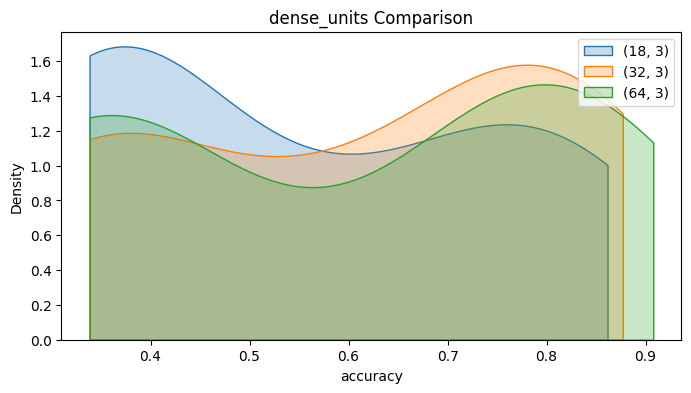

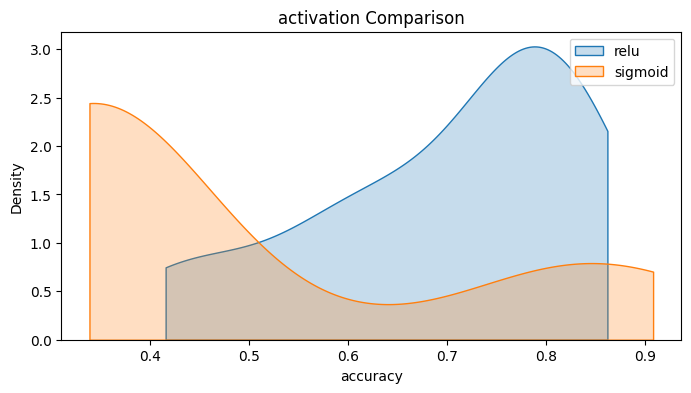

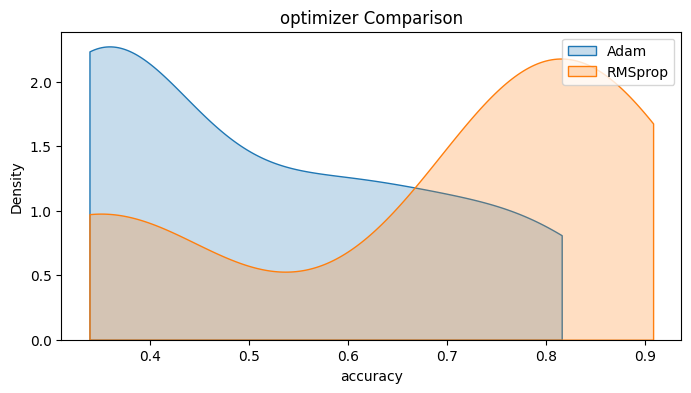

In [32]:
# Only want to plot the parameters that were tested.
for param in [c for c in hyperparams if c not in ['batch_size', 'epochs', 'dropout', 'earlystop_patience', 'reducel_patience']]:
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f'{param} Comparison')
    for group, group_df in full_results_batch2.groupby(param):
        sns.kdeplot(group_df['accuracy'], label=group, cut=0, fill=True, ax=ax)
    _ = plt.legend()
    plt.show()

After looking through the 2nd batch of results, here are some takeaways:
- augmentation_params: Just like in the 1st batch of models, the augmentation layer appears to provide no benefit. I believe the neural network is able to overcome the limitations in the data on its own.
- cnn_params: Interestingly, the more complicated feature extraction configuration turned out to be best. Recall in the 1st batch of modeling that the data was trending in the direction that more complicated CNN layers were worse. Due to this, I don't know if I have a definitive answer on how deep the feature extraction portion of the CNN model needs to be. One difference here is that the models for batch #1, used larger filters and stides in the first layer segment of the deeper CNN model. So at the very least, the filter should stay at 3x3 and stride at 1x1.
- dense_units: Using 64 units in the classification portion of the CNN model turns out to be best, just like what the 1st batch of modeling results suggested. The results do almost look negligible, but a higher dense unit count appears to be better.
- activation: The sigmoid activation function lead to higher accuracy when comparing to relu. I don't really like how thin the distribution is at the right tail for the sigmoid distribution. The relu activation I believe would still be safer to use.
- optimizer: RMSprop is the clear winner for the best optimizer for this task. The distribution looks good so I believe RMSprop will be best to use going forward.

Before making a decision on what to do next, I'll take a look at the best model so far which is model-23 from model batch #2.

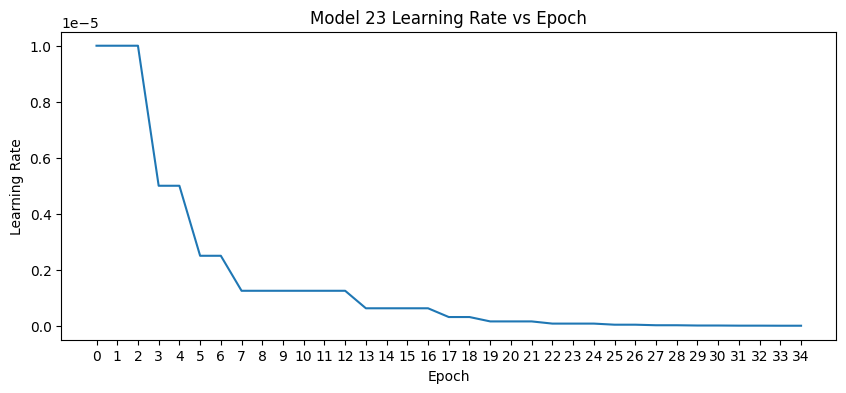

In [33]:
plot_learning_rate(model_data_batch2['model23']['model_history'], 23, width=10)

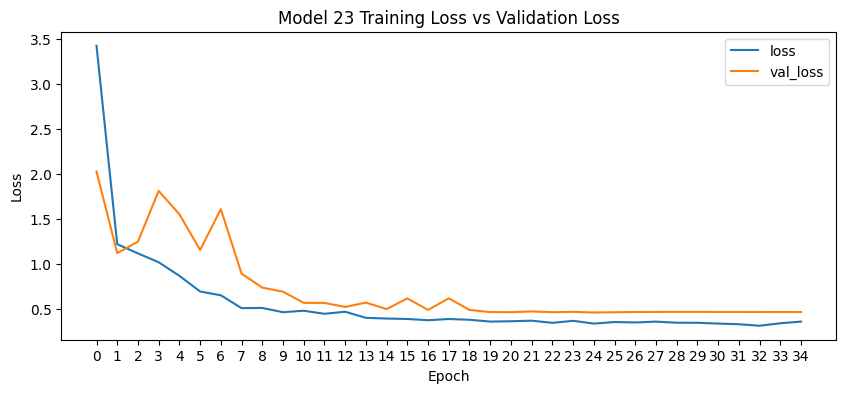

In [34]:
plot_metric(model_data_batch2['model23']['model_history'], 'loss', 23, width=10)

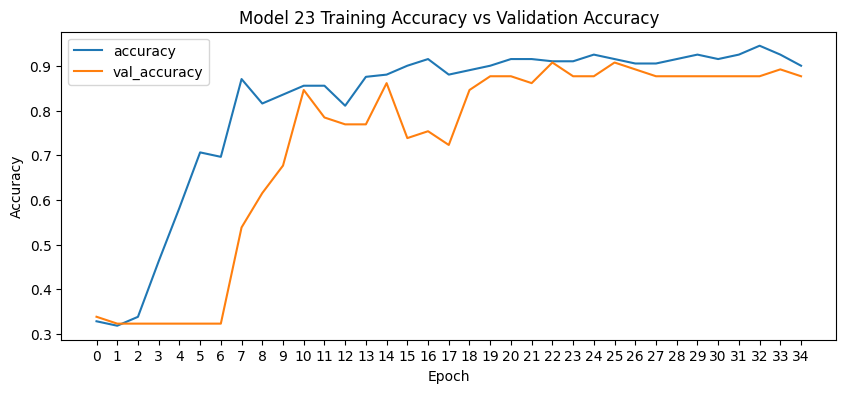

In [35]:
plot_metric(model_data_batch2['model23']['model_history'], 'accuracy', 23, width=10)

Overall it looks like the training for model-23 went well. I do not see any particularly bad signs of overfitting. Recall that the final epoch used for model-23 was epoch #23 due to validation monitoring implemented in the model.

I'll take everything I've learned so far and create 1 final batch of models [Multi_Model_Building_(Batch_3)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_3)_trained.ipynb) with these parameters. (I'll list out the new parameters, but will skip the re-explanations again.) I am primarily wanting to only alter the parameters where its not clear what the best value to use is.

- `g_batch_size = [4]`
- `g_epochs = [35]`
- `g_augmentation_params = [None]`
- `g_cnn_params = [[(32,), [(3,3)], [(1,1)]], [(32, 64), [(3,3), (3,3)], [(1,1), (1,1)]], [(32, 64, 128), [(3,3), (3,3), (3,3)], [(1,1), (1,1), (1,1)]]]`
- `g_dropout = [0]`
- `g_dense_units = [(64, 3), (128, 3)]`
- `g_activation = ['relu', 'sigmoid']`
- `g_optimizer = [RMSprop]`
- `g_earlystop_patience = [10]`
- `g_reducel_patience = [2]`

There are a total of **12** models fitted in the final batch using this notebook [Multi_Model_Building_(Batch_3)](https://github.com/rpforrest1/Bear_Classification_CNN_Project/blob/main/model_building/trained_notebooks/Multi_Model_Building_(Batch_3)_trained.ipynb). I will go through some results below.

In [36]:
# Load result for modeling batch #3 (final batch)
progress_batch3, model_data_batch3, all_val_metrics_batch3, full_results_batch3 = load_results('./model_building/model_checkpoints_3')
print(bold(f'Top 10 accuracy values on validation dataset.'))
display(all_val_metrics_batch3.sort_values('accuracy', ascending=False).head(10))

Top 10 accuracy values on validation dataset.


,loss,accuracy,total_time,ran_epochs,best_epoch
model5,0.464846,0.907692,168.910560,33,23
model9,0.442656,0.892308,123.351029,25,15
model7,0.464231,0.876923,210.319608,34,24
model11,0.371048,0.876923,167.189076,31,21
model2,0.937980,0.846154,235.643171,29,19
model6,0.558538,0.815385,131.550743,21,11
model8,0.884146,0.784615,104.560599,21,11
model0,0.996012,0.784615,147.003345,25,15
model10,0.604473,0.784615,130.212548,24,14
model4,0.615602,0.738462,105.287196,21,11


In [37]:
print(bold('Model configuration for model-5'))
display(progress_batch3.loc['model5'])

Model configuration for model-5


batch_size                                                          4
epochs                                                             35
augmentation_params                                              None
cnn_params             [(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]
dropout                                                             0
dense_units                                                   (64, 3)
activation                                                    sigmoid
optimizer                                                     RMSprop
earlystop_patience                                                 10
reducel_patience                                                    2
finished                                                         True
Name: model5, dtype: object

So for the best model in the final batch (model-5), its actually the same modeling parameters as model-23 from modeling batch #2. Overall, I was not able to find any parameters that results in better accuracy. On a positive note, many model from this batch performed better than the previous 2 runs. I'll go through these results to see what can be learned.

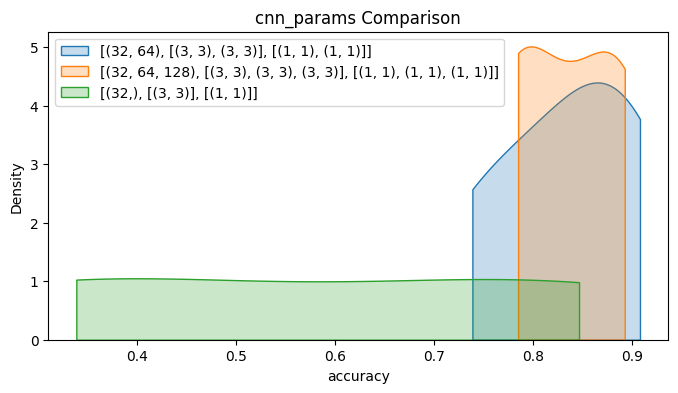

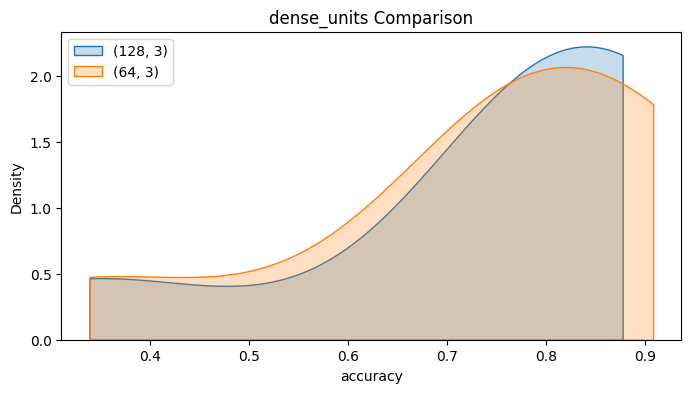

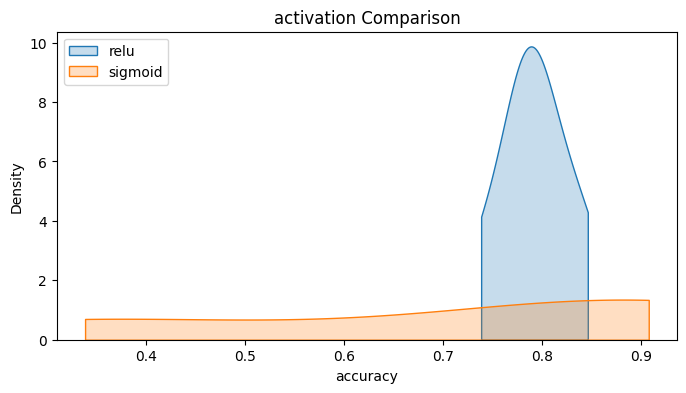

In [38]:
# Only want to plot the parameters that were tested.
for param in ['cnn_params', 'dense_units', 'activation']:
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f'{param} Comparison')
    for group, group_df in full_results_batch3.groupby(param):
        sns.kdeplot(group_df['accuracy'], label=group, cut=0, fill=True, ax=ax)
    _ = plt.legend(loc='upper left')
    plt.show()

After looking through the 3rd/final batch of results, here are some takeaways:
- cnn_params: Although earlier results suggested that a more complicated feature extraction section lead to better accuracy, the results from this shows that there is a limit. So the best version to use would be right in the middle of too simple and too complicated.
- dense_units: Earlier results also suggested that higher units in the classifier lead to better accuracy. From this testing, it appears that 64 units will do just fine.
- activation: The choice of activation function was yet again an interesting result. The sigmoid activation function is able to provide better accuracy, but its not as consistant as the relu activation function.

---

## Results and Analysis

Now I'll provide a broad overview of the results and choose a models (or models) to check the test set performace. So far, the test set has not been ran so this will provide a good gauge on real world performance.

First, lets combine all modeling batch runs and see what the model options are.

In [39]:
full_results_batch1.insert(0, value=1, column='batch_num')
full_results_batch2.insert(0, value=2, column='batch_num')
full_results_batch3.insert(0, value=3, column='batch_num')

In [40]:
# Combine results
full_results = pd.concat([
    full_results_batch1.reset_index(),
    full_results_batch2.reset_index(),
    full_results_batch3.reset_index()
], ignore_index=True)

In [41]:
print(bold(f'Top 10 accuracy values on validation dataset.'))
display(full_results.sort_values('accuracy', ascending=False).head(10))

Top 10 accuracy values on validation dataset.


,index,batch_num,loss,accuracy,total_time,ran_epochs,best_epoch,batch_size,epochs,augmentation_params,cnn_params,dropout,dense_units,activation,optimizer,earlystop_patience,reducel_patience,finished
78,model23,2,0.464846,0.907692,173.929025,35,23,4,35,None,"[(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]",0,"(64, 3)",sigmoid,RMSprop,15,2,True
114,model5,3,0.464846,0.907692,168.910560,33,23,4,35,None,"[(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]",0,"(64, 3)",sigmoid,RMSprop,10,2,True
112,model9,3,0.442656,0.892308,123.351029,25,15,4,35,None,"[(32, 64, 128), [(3, 3), (3, 3), (3, 3)], [(1,...",0,"(64, 3)",sigmoid,RMSprop,10,2,True
123,model11,3,0.371048,0.876923,167.189076,31,21,4,35,None,"[(32, 64, 128), [(3, 3), (3, 3), (3, 3)], [(1,...",0,"(128, 3)",sigmoid,RMSprop,10,2,True
121,model7,3,0.464231,0.876923,210.319608,34,24,4,35,None,"[(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]",0,"(128, 3)",sigmoid,RMSprop,10,2,True
87,model19,2,0.506365,0.876923,155.425694,35,21,4,35,None,"[(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]",0,"(32, 3)",sigmoid,RMSprop,15,2,True
71,model25,2,0.573150,0.861538,233.159757,35,20,4,35,"(True, 0.5, 0.5, 'horizontal')","[(32,), [(3, 3)], [(1, 1)]]",0,"(18, 3)",relu,RMSprop,15,2,True
73,model47,2,0.609000,0.861538,191.594647,32,17,4,35,"(True, 0.5, 0.5, 'horizontal')","[(32, 64), [(3, 3), (3, 3)], [(1, 1), (1, 1)]]",0,"(64, 3)",sigmoid,RMSprop,15,2,True
84,model5,2,0.508481,0.861538,122.105866,26,11,4,35,None,"[(32,), [(3, 3)], [(1, 1)]]",0,"(32, 3)",relu,RMSprop,15,2,True
115,model2,3,0.937980,0.846154,235.643171,29,19,4,35,None,"[(32,), [(3, 3)], [(1, 1)]]",0,"(128, 3)",relu,RMSprop,10,2,True


In the table above, the models are ranked by performance but also we are able to see what parameters were used. So far, the best model based on validation performance is model-23 from batch 2 with an accuracy of 90.77%. I would also like to pick another model that could be a little more conservative. I prefer to use models that are as simple as possible, and have a good chance of not experiencing overfitting. For these reasons, I'm also interested in looking at model-25 from batch 2. Its a simpler model but was still able to acheive an accuracy of 86.15%.

In [42]:
def get_test_results(model_name, progress_batch, model_data_batch):
    """
    Args:
        model_name: The model's name
        progress_batch: The loaded progress_batch dataframe
        model_data_batch: The loaded model_data_batch dictionary
    
    Returns:
        A tuple with the model and the test metrics.
    """
    
    _, _, _, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, progress_batch.loc[model_name]['batch_size'])
    model = tf.keras.models.load_model(model_data_batch[model_name]['checkpoint'])
    test_metrics = model.evaluate(test_ds, verbose=0)
    test_metrics = map_to_metrics(model.metrics_names, test_metrics)

    return model, test_metrics

Lets load in model-23 and model-25, both from the model batch fit #2. Once loaded, the test set performance will be calculated.

In [43]:
model_23, test_metrics_model_23 = get_test_results('model23', progress_batch2, model_data_batch2)
model_25, test_metrics_model_25 = get_test_results('model25', progress_batch2, model_data_batch2)
print(f"Batch #2 model-23 test set accuracy: {test_metrics_model_23['accuracy']:.2%}")
print(f"Batch #2 model-25 test set accuracy: {test_metrics_model_25['accuracy']:.2%}")

Batch #2 model-23 test set accuracy: 72.73%
Batch #2 model-25 test set accuracy: 68.18%


The test set results are very interesting. When looking at the performance difference between the 2 models, there was about 4 percentage points between the validation scores. The same 4 percentage point delta seemed to have carried over when evaluating the test set results. The unfortunate outcome was the scores are noticably worse than what it was during training. There is almost an 18 percentage point decline from the validation accuracy to the test accuracy.

Since model-23's training graphs were already shown in another section, I'll display the training graphs for model-25 to see if anything unusual appears.

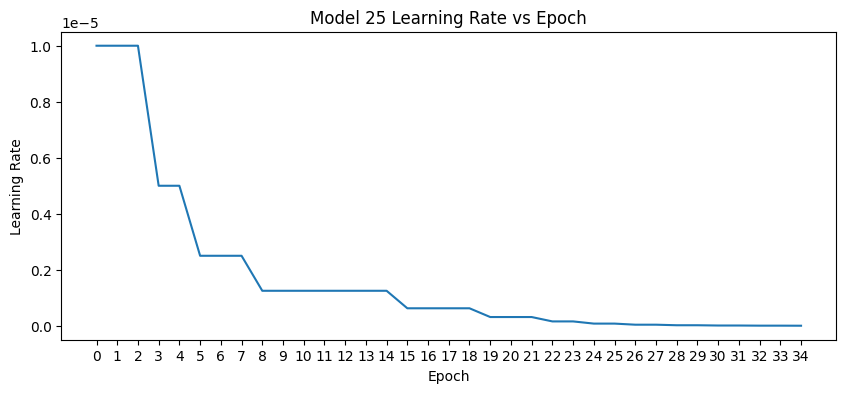

In [44]:
plot_learning_rate(model_data_batch2['model25']['model_history'], 25, width=10)

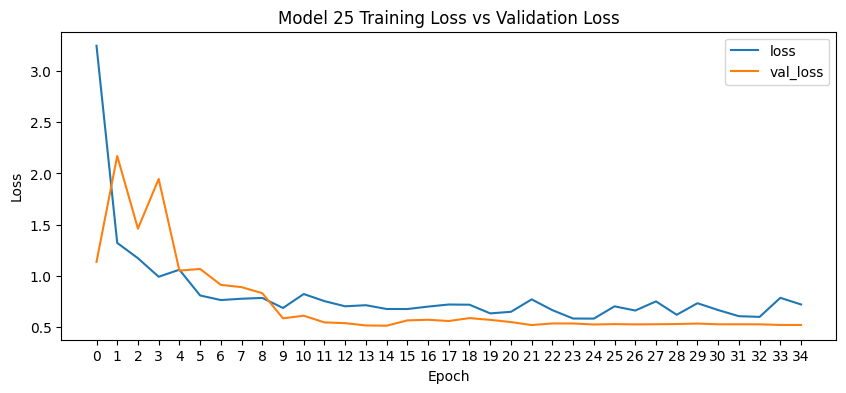

In [45]:
plot_metric(model_data_batch2['model25']['model_history'], 'loss', 25, width=10)

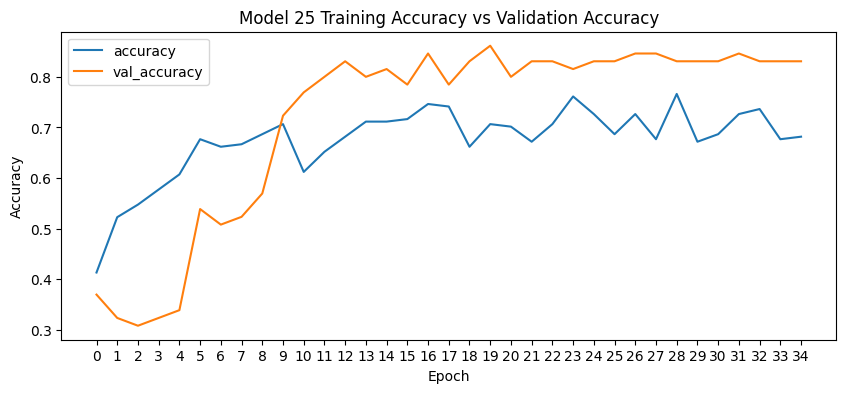

In [46]:
plot_metric(model_data_batch2['model25']['model_history'], 'accuracy', 25, width=10)

The training graphs for model-25 show some interesting behavior. It appears that the validation loss and accuracy, eventually become better than the training loss and accuracy. I believe this is being caused by the data augmentation that is being applied to the model. The model isn't necessairly able to "overfit" to the training data since the training data is essentially being changed during every epoch. The best epoch for this model was epoch #20.

So in conclusion, I believe sticking with **model-23** from modeling batch #2 will be the best model overall. I do not see any negatives from its usage.

Lets take a look at the confusion matrix for the test set in order to get an idea of what the potential strengths and weaknesses are.

In [47]:
#Get the tensorflow datasets and predict in the test set.
_, _, test_ds_str, _, _, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, progress_batch2.loc['model23']['batch_size'])
y_true, y_pred, y_pred_proba, c_matrix = calculate_performance(model_23, test_ds)

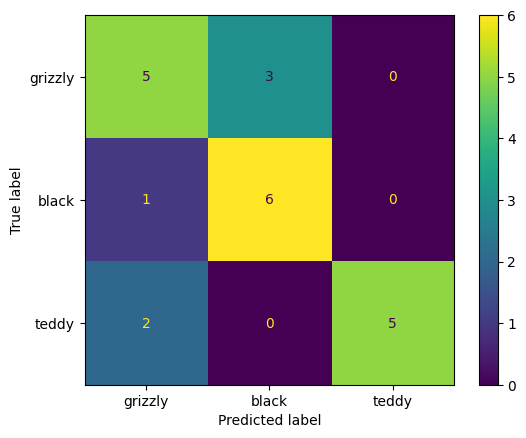

In [48]:
c_matrix.plot()
plt.show()

Based on the results, model-23 does well to not categorize grizzly or black bears as teddy bears. Overall, it looks like the model has the least amount of errors when classifying teddy bears. When looking at classifying black and grizzly bears, the primary struggle is mistakenly classifying grizzly bears as black bears. It does not miscategorize the other way around very often.

In [49]:
def plot_misclass(y_true, y_pred, dataset_str):
    """
    Plots example images.

    Args:
        y_true: The array of true/actual labels.
        y_pred: The array of predicted labels.
        dataset_str: The tensorflow dataset object that is sting in the string format.
        
    Returns:
        None. Displays the plot
    """
    
    misclass_mask = y_true != y_pred
    misclass_str = np.array(list(map(lambda x: x.decode(), dataset_str.as_numpy_iterator())))[misclass_mask]
    misclass = list(map(Image.open, misclass_str))
    num_img = len(misclass)

    plt.figure(figsize=(num_img*2, num_img*1.5))
    plt.suptitle('Misclassified Test Images', fontsize=20)
    for i, (yt, yp, img) in enumerate(zip(y_true[misclass_mask], y_pred[misclass_mask], misclass)):
        ax = plt.subplot(int(num_img/2), int(num_img/2), i + 1, title = f'Label: {CLASS_NAMES[yt]} | Predicted: {CLASS_NAMES[yp]}')
        plt.imshow(img)
        plt.subplots_adjust(wspace=0.1, hspace=0.15)
        plt.axis("off")

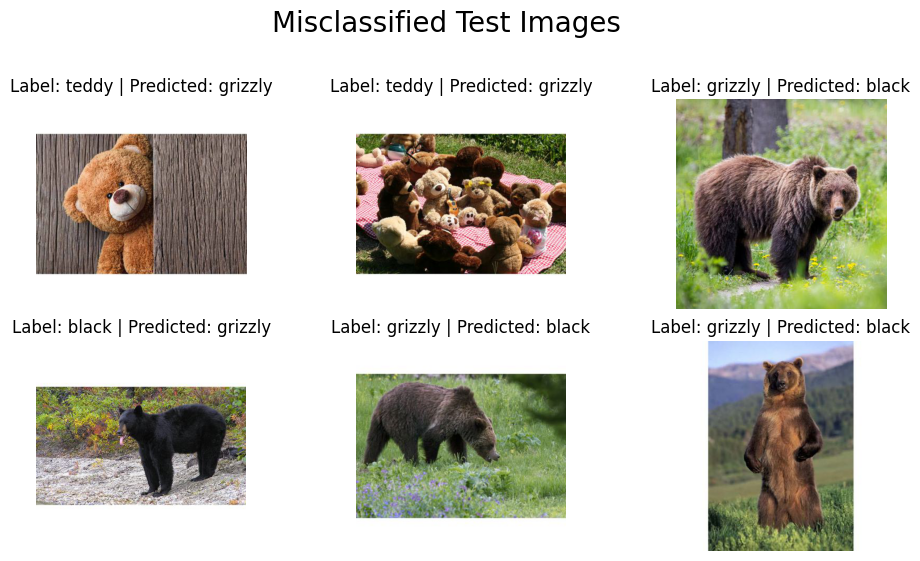

In [50]:
plot_misclass(y_true, y_pred, test_ds_str)

Shown above are the images that were misclassified in the test dataset. For the 2 teddy bear images, I believe that the misclassification could be due to the amount of brown in the images. For the other images of grizzly and black bears, I don't have a theory as to why they would be misclassified. I think in general those 2 bear types are very similar so the model is having a difficult time distinguishing between them.

Now that I've gone through the chosen model results in detail, next I'll provide an overview on the hyperparameters by discussing what ended up working the best.
- **batch_size:** A lower batch size is better. I believe its because it allows for more parameter updates.
- **epochs:** Capping epochs at 35 turned out well. The final epoch used in the fitted models were handled by the early stopping, so the risk of overfitting was reduced.
- **augmentation_params:** Having no data augmentation was best when looking at the scores. I'm not exactly sure why the augmentation layer didn't help improve results more. I believe it could be that the amount of data was already fine.
- **cnn_params:** A less complicated feature extraction network was better. Its possible to have a deeper network, but the accuracy results were not consistant. I believe this task does not require a complicated network.
- **dropout:** Having no dropout was best. I believe the batch normalization thats happening in the network is already doing a good job at reducing overfitting.
- **dense_units:** Having a classification network of 64 unis followed by 3 units was best. Having too few units provided worse results, and higher units didn't do as well, but still managed good enough.
- **activation:** The sigmoid activation function provided the best results. Relu would typically be used, and its still a good activation function to use that provided more consistant results when compared to the sigmoid function.
- **optimizer:** The RMSprop optimizer had the best time finding the optimum parameters for this task. Adam still performed well overall.
- **earlystop_patience:** This parameter mostly served as a way to prevent overfitting and to allow the model to potentailly get out of any local minimums. Anything between 10 and 15 was good to use.
- **reducel_patience:** This parameter also helped the model find its optimum parameters by reducing the learning rate if the model was getting worse. As long as this parameter was used, it was helpful. So a value between 1 and 2 worked out well.

The primary troubleshooting for this modeling task was needed during the data prep phase. The images were not able to be read in correctly due to all of the different file types and sizes. This was mitigated by standardizing the images before the model read the images in. Another issue faced during the modeling was that fitted models in tensorflow would not load onto a different machine. I tried fitting models on a server and then loaded them locally. Once loaded locally, I was not able to produce the same output that the server had. After many attemps to have identical environments, ultimately I was not able to solve the issue so all model fitting was done locally. This meant that I was not able to fit as many model as I would have liked.

---

## Conclusion

In summary, the best performing model for this task used a VGGNet based architecture that used \[Conv(kernal_size= 32, 3x3 filters, 1x1 stride) , BatchNorm, Sigmoid Activation -> Conv(kernal size= 32, 3x3 filters, 1x1 stride) , BatchNorm, Sigmoid Activation -> MaxPool(2x2)] -> \[Conv(kernal_size= 64, 3x3 filters, 1x1 stride) , BatchNorm, Sigmoid Activation -> Conv(kernal size= 64, 3x3 filters, 1x1 stride) , BatchNorm, Sigmoid Activation -> MaxPool(2x2)] -> Fully connected layer with 64 units -> Dense layer with 3 units. The optimizer was RMSprop, batch size was set to 4, max epoch set to 35, no data augmentation used, no dropout used, an early stopping patience of 15 and a reduce learning rate patience of 2. This model got a validation accuracy of 90.8% and a test accuracy of 72.7%. Using the modeling pipeline that I setup for this project proved extremely beneficial in determining what the most optimal parameters were. 

One takeaway I had from this project was that there seems to be a limit on how beneficial regularization techniques can be. For example, adding in dropout and data augmentation, did not reliably lead to better results. I believe as long as some techniques are used when building a model, you don't need to worry about trying to add in as many as possible. So in the future, I plan to only use some techniques. Extra regularization is something that didn't end up working. I believe adding in more regularization than necessary, ends up "smoothing" out the data too much that the important pieces of information ends up being lost. Something else that didn't turn out well was making the feature extraction section of the CNN model more complicated. I believe this is mostly seen as "normal" since often time when a network becomes too complicated, the model starts to perform worse. This worse performance can be attributed to the increased number of parameters and the tendency for the model to overfit to the training data.  

I believe something that can improve this model would be to add more data. With around 100 images per class, I still do not think that is a healthy amount to create a reliable model with. Another suggestion would be to try out different architectures such as InceptionNet or ResNet. Perhaps the best option is to take a pre-existing model and fine tune it to this dataset. I believe that finding a pretuned model would be the option that would increase the performance the most.

---

## References
- https://www.tensorflow.org/tutorials/keras/classification

---